<a href="https://colab.research.google.com/github/McPetzka/Out-there-UFO-data/blob/main/Out_there_UFO_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

In [41]:
data= pd.read_csv('scrubbed.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.



EDA and data cleansing

In [9]:
from pandas_profiling import ProfileReport

In [13]:
profile =ProfileReport(data)
profile.to_file('UFOProfile.html')
profile

In [42]:
data[['date','time']] = data['datetime'].str.split(expand=True)
data[['date','time']] = data['datetime'].str.split(expand=True)
data['datetime'] = (pd.to_datetime(data.pop('date'), format='%m/%d/%Y') + 
                  pd.to_timedelta(data.pop('time') + ':00'))


In [43]:
data['datetime'] 

0       1949-10-10 20:30:00
1       1949-10-10 21:00:00
2       1955-10-10 17:00:00
3       1956-10-10 21:00:00
4       1960-10-10 20:00:00
                ...        
80327   2013-09-09 21:15:00
80328   2013-09-09 22:00:00
80329   2013-09-09 22:00:00
80330   2013-09-09 22:20:00
80331   2013-09-09 23:00:00
Name: datetime, Length: 80332, dtype: datetime64[ns]

In [44]:
print(data[data['latitude'].str.contains('[A-Za-z]', na=False)]) # checking if column contains non numerical characters as it figues as object data kind

                 datetime                          city  ...    latitude  longitude 
43782 1974-05-22 05:30:00  mescalero indian reservation  ...  33q.200088 -105.624152

[1 rows x 11 columns]


In [45]:
data= data.drop([43782]) # removing the row containing non numerical value

In [46]:
data = data.reset_index(drop=True)

In [47]:
data['latitude_num']=data['latitude'].astype('float64') # transforming to numerical data type

In [48]:
data[data['duration (seconds)'].str.contains("`",na=False)] # checking for additional characters in the column

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,latitude_num
27822,2000-02-02 19:33:00,bouse,az,us,NaN,2`,each a few seconds,Driving through Plomosa Pass towards Bouse Loo...,2/16/2000,33.9325000,-114.005000,33.932500
35692,2005-04-10 22:52:00,santa cruz,ca,us,NaN,8`,eight seconds,2 red lights moving together and apart with a ...,4/16/2005,36.9741667,-122.029722,36.974167
58590,2006-07-21 13:00:00,ibague (colombia),NaN,NaN,circle,0.5`,1/2 segundo,Viajaba a 27.000 pies en un avion comercial ve...,10/30/2006,4.440663,-75.244141,4.440663


In [49]:
data.loc[27822,'duration (seconds)'] = 2
data.loc[35692,'duration (seconds)'] = 8
data.loc[58590,'duration (seconds)'] = 0.5

In [50]:
data['duration(seconds)_num']=data['duration (seconds)'].astype('float64') # transforming to numerical data type

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80331 entries, 0 to 80330
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               80331 non-null  datetime64[ns]
 1   city                   80331 non-null  object        
 2   state                  74534 non-null  object        
 3   country                70662 non-null  object        
 4   shape                  78399 non-null  object        
 5   duration (seconds)     80331 non-null  object        
 6   duration (hours/min)   80331 non-null  object        
 7   comments               80316 non-null  object        
 8   date posted            80331 non-null  object        
 9   latitude               80331 non-null  object        
 10  longitude              80331 non-null  float64       
 11  latitude_num           80331 non-null  float64       
 12  duration(seconds)_num  80331 non-null  float64       
dtypes

In [29]:
!pip install reverse-geocode

     |████████████████████████████████| 1.6MB 11.4MB/s 
  Created wheel for reverse-geocode: filename=reverse_geocode-1.4.1-cp36-none-any.whl size=1637843 sha256=9f23d8bdb5f3126f5008d6525c18263207438b3e93291ebc6e86f01e7cbb9272
  Stored in directory: /root/.cache/pip/wheels/bb/20/42/0f783ab28c022f828cb35756d3c9606bb20c560f1535a0b758
Successfully built reverse-geocode


In [30]:
import reverse_geocode as rg # Fill in missing countries by matching longitude/latitude data available with corresponding country area (reverse geocode)

In [52]:
coordinates = list(zip(data['latitude_num'], data['longitude ']))
results = rg.search(coordinates)
results_df = pd.DataFrame(results)

results_df.head()

,country_code,city,country
0,US,Geronimo,United States
1,US,Lackland Air Force Base,United States
2,GB,Blacon,United Kingdom
3,US,Edna,United States
4,US,He‘eia,United States


In [53]:
data['country_c']=results_df['country_code']
data['country_df'] = results_df['country']


In [54]:
data['shape'] = data['shape'].fillna("No data")
data['comments'] = data['comments'].fillna("No data")

In [55]:
data['duration(minutes)_num']=data['duration(seconds)_num'] /60
data['duration(minutes)_num']

0         45.000000
1        120.000000
2          0.333333
3          0.333333
4         15.000000
            ...    
80326     10.000000
80327     20.000000
80328     20.000000
80329      0.083333
80330     17.000000
Name: duration(minutes)_num, Length: 80331, dtype: float64

In [56]:
data.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude ', 'latitude_num', 'duration(seconds)_num', 'country_c',
       'country_df', 'duration(minutes)_num'],
      dtype='object')

In [57]:
data = data.rename(columns={'country_df': 'country_full',
                            'latitude_num': 'latitude',
                            'country_c': 'country code',
                            'duration(minutes)_num': 'duration(minutes)'}) # replacing columns with updated ones

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80331 entries, 0 to 80330
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               80331 non-null  datetime64[ns]
 1   city                   80331 non-null  object        
 2   state                  74534 non-null  object        
 3   country                70662 non-null  object        
 4   shape                  80331 non-null  object        
 5   duration (seconds)     80331 non-null  object        
 6   duration (hours/min)   80331 non-null  object        
 7   comments               80331 non-null  object        
 8   date posted            80331 non-null  object        
 9   latitude               80331 non-null  object        
 10  longitude              80331 non-null  float64       
 11  latitude               80331 non-null  float64       
 12  duration(seconds)_num  80331 non-null  float64       
 13  c

In [59]:
data['comments'] = data['comments'].replace({';': ' '}, regex=True)

UFO Shapes Sightings

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



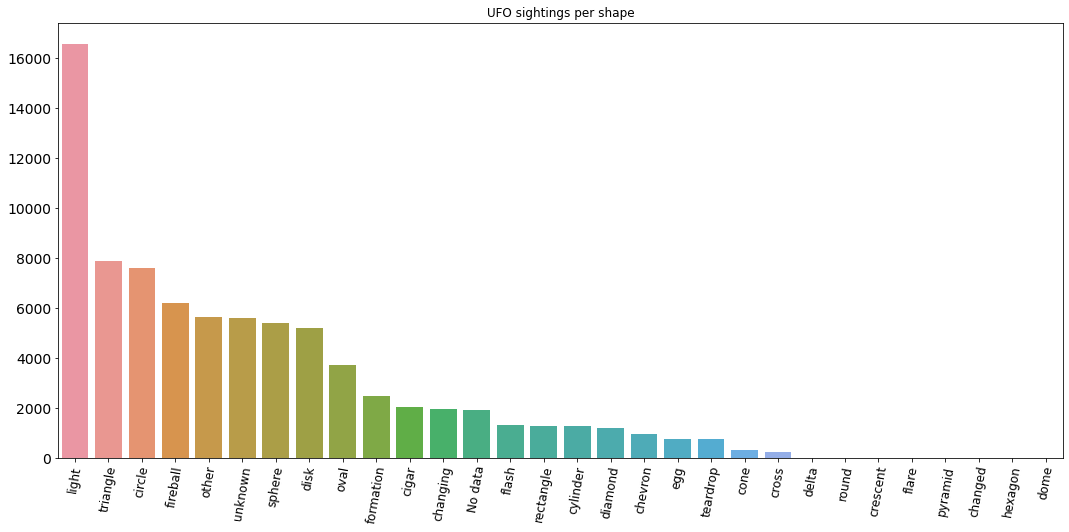

In [70]:
shape_ufo =data['shape'].value_counts().index
shape_ratio =data['shape'].value_counts().values
plt.figure(figsize=(18,8)),
sns.barplot(shape_ufo, shape_ratio)
plt.title('UFO sightings per shape')
plt.xticks(rotation=80,fontsize=12)
plt.yticks(fontsize=14)
plt.show()

Duration of UFO Sighting

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



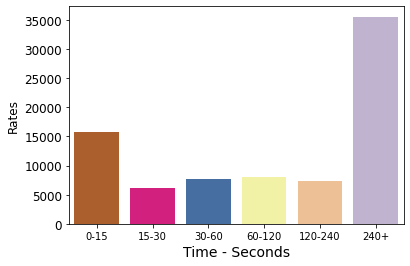

In [72]:
bins = [0, 15, 30, 60, 120, 240, np.inf]
names = ['0-15', '15-30', '30-60', '60-120', '120-240','240+']

data['bins_time'] = pd.cut(data['duration(seconds)_num'], bins, labels=names)

bx= data['bins_time'].value_counts().index
by=data['bins_time'].value_counts().values

sns.barplot(bx, by, palette = "Accent_r")
plt.xlabel("Time - Seconds",fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel("Rates",fontsize=12)
plt.yticks(fontsize=12)

plt.show() 

UFO sightings per month

In [66]:
data['month'] = pd.DatetimeIndex(data['datetime']).month

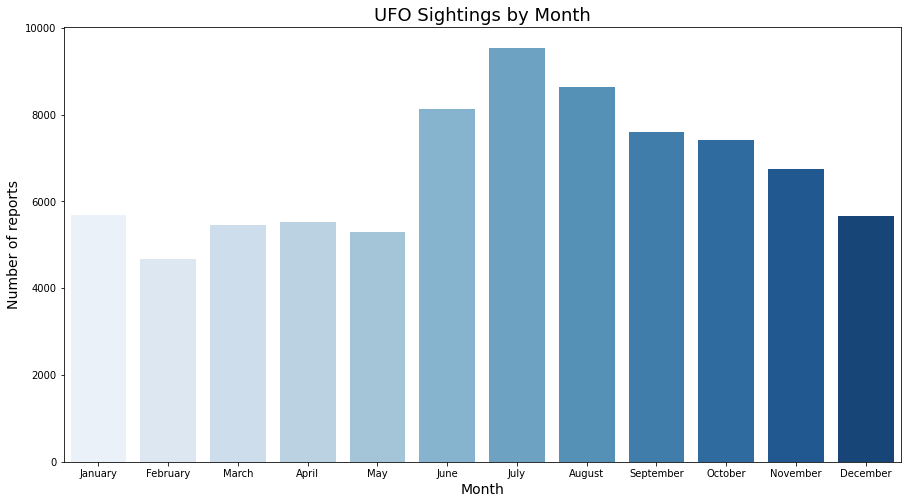

In [67]:
order = ["January", "February", "March", "April", "May", "June", "July","August", "September", 
         "October", "November", "December"]
data['month'] = data['datetime'].dt.month_name()
month_data = data['month'].value_counts() 
month_index = month_data.index 
month_values = month_data.values
plt.figure(figsize=(15,8))
plt.title('UFO Sightings by Month', fontsize=18)
plt.xlabel("Month",fontsize=14)
plt.ylabel("Number of reports", fontsize=14)
month_plot = sns.barplot(x=month_index[:60],y=month_values[:60], palette = "Blues", order=order)

UFO sightings by time(hour)

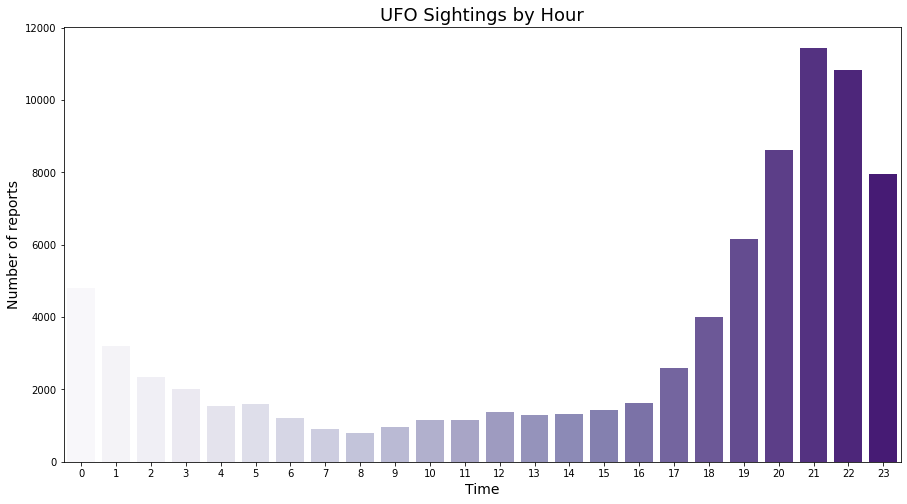

In [74]:
data['hour'] = pd.DatetimeIndex(data['datetime']).hour
hour_data = data['hour'].value_counts() 
hour_index = hour_data.index 
hour_values =hour_data.values
plt.figure(figsize=(15,8))
plt.title('UFO Sightings by Hour', fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Number of reports", fontsize=14)
hour_plot = sns.barplot(x=hour_index[:60],y=hour_values[:60], palette = 'Purples')

Most frequent words to describe UFO sightings

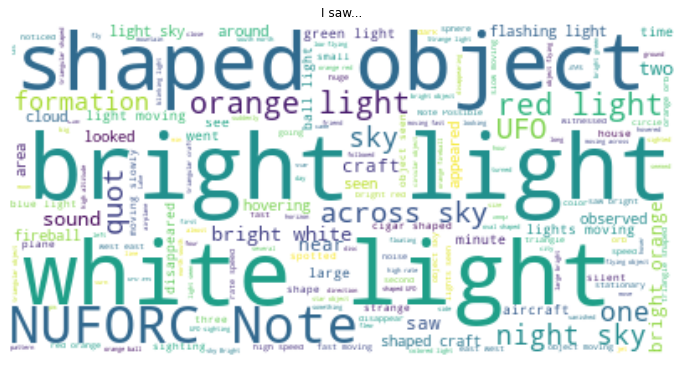

In [78]:
from wordcloud import WordCloud

text = " ".join(str(word) for word in data.comments)
wordcloud =WordCloud(max_words= 600,background_color="white").generate(text)
plt.figure(figsize= (12,9))
plt.title('I saw...')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()